# Modern Artificial Intelligence: Project Notebook

**Team Name:** Mighty Ducks

**Team Members:** Harpreet Kaur Setia, Micaiah Lowe, Rachel Raifsnider and Samantha Fildish

**Project Summary:** Inspired by a Kaggle competition, our team would like to build an NLP classifier, which would utilize a state-of-the-art pre-training technique called Bidirectional Encoder Representations from Transformers (BERT) and other Machine-Learning methods. Along side text classification, we aim to incorporate Sentiment Analysis to annotate tweets with sentiment labels, e.g. negative, neutral, or positive, and then compare the results with true class labels to see if a correlation exists between sentiment and the classified tweets. If so, we would attempt to add sentiments as an additional feature to our model, along with the raw text, to improve the model’s accuracy.


## Importing Packages

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import re
import os

import tensorflow as tf
from tensorflow import keras
pd.set_option('display.max_rows', None)

In [ ]:
!pip install transformers

     |████████████████████████████████| 4.2 MB 5.3 MB/s 
     |████████████████████████████████| 84 kB 2.7 MB/s 
     |████████████████████████████████| 596 kB 33.5 MB/s 
     |████████████████████████████████| 6.6 MB 36.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import transformers
from transformers import BertTokenizer, pipeline
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification
from transformers import DefaultDataCollator

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers.schedules import PolynomialDecay

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Reading Original Data

In [ ]:
# Loading the training data
base_train_df = pd.read_csv("/content/drive/MyDrive/MSBC_5190_Project/Data/Original/train.csv")

# Loading the test data
base_test_df = pd.read_csv("/content/drive/MyDrive/MSBC_5190_Project/Data/Original/test.csv")

## Finding Polarity (Sentiment) on Tweets

Originally we applied this step after pre-processing the text; however, we determined that the model from Huggingface, `finiteautomata/bertweet-base-sentiment-analysis`, would perform better on unprocessed tweets in the column `text`.

***Note: The original dataset form Kaggle purposely left our the `target` values for the test set. This is most likely because it comes form a Kaggle competition and they wish to hide final results from competitors.***

In [ ]:
# Set up the inference pipeline using a model from the 🤗 Hub
sentiment_analysis = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis")

def finiteautomata_prediction(x):
    sentiment = sentiment_analysis(x)
    score = sentiment[0]['label']
    return score

Downloading:   0%|          | 0.00/0.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/890 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/515M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/295 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/824k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Please install emoji: pip3 install emoji


In [ ]:
# Run defined function `finiteautomata_prediction` on both dataframes and create a new column called `sentiment`
base_train_df['sentiment'] = base_train_df['text'].apply(finiteautomata_prediction)
base_test_df['sentiment'] = base_test_df['text'].apply(finiteautomata_prediction)

In [ ]:
base_train_df.dtypes

id            int64
keyword      object
location     object
text         object
target        int64
sentiment    object
dtype: object

In [ ]:
base_train_df.head()

,id,keyword,location,text,target,sentiment
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,NEU
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,NEU
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,NEU
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,NEU
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,NEU


In [ ]:
base_test_df.head()

,id,keyword,location,text,sentiment
0,0,NaN,NaN,Just happened a terrible car crash,NEG
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",NEU
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",NEG
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,NEG
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,NEG


In [ ]:
# Show a tweet for each sentiment
display(base_train_df[base_train_df["sentiment"] == 'POS'].head(1))
display(base_train_df[base_train_df["sentiment"] == 'NEU'].head(1))
display(base_train_df[base_train_df["sentiment"] == 'NEG'].head(1))

,id,keyword,location,text,target,sentiment
16,24,NaN,NaN,I love fruits,0,POS


,id,keyword,location,text,target,sentiment
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,NEU


,id,keyword,location,text,target,sentiment
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1,NEG


In [ ]:
# Show a tweet for each sentiment
display(base_test_df[base_test_df["sentiment"] == 'POS'].head(1))
display(base_test_df[base_test_df["sentiment"] == 'NEU'].head(1))
display(base_test_df[base_test_df["sentiment"] == 'NEG'].head(1))

,id,keyword,location,text,sentiment
7,22,NaN,NaN,Hey! How are you?,POS


,id,keyword,location,text,sentiment
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",NEU


,id,keyword,location,text,sentiment
0,0,NaN,NaN,Just happened a terrible car crash,NEG


## Writing New Dataframe to CSV

In [ ]:
# Train
base_train_df.to_csv("/content/drive/MyDrive/MSBC_5190_Project/Data/Tweets with Sentiment/train_sentiment.csv")
# Test
base_test_df.to_csv("/content/drive/MyDrive/MSBC_5190_Project/Data/Tweets with Sentiment/test_sentiment.csv")

## Reading Data with Sentiment Labels

In [ ]:
# Loading the training data
base_train_df = pd.read_csv("/content/drive/MyDrive/MSBC_5190_Project/Data/Tweets with Sentiment/train_sentiment.csv", index_col=0)

# Loading the test data
base_test_df = pd.read_csv("/content/drive/MyDrive/MSBC_5190_Project/Data/Tweets with Sentiment/test_sentiment.csv", index_col=0)

In [ ]:
# Show 5 rows for train dataframe
base_train_df[10:15]

,id,keyword,location,text,target,sentiment
10,16,NaN,NaN,Three people died from the heat wave so far,1,NEG
11,17,NaN,NaN,Haha South Tampa is getting flooded hah- WAIT ...,1,NEG
12,18,NaN,NaN,#raining #flooding #Florida #TampaBay #Tampa 1...,1,NEG
13,19,NaN,NaN,#Flood in Bago Myanmar #We arrived Bago,1,NEU
14,20,NaN,NaN,Damage to school bus on 80 in multi car crash ...,1,NEG


In [ ]:
# Show 5 rows for test dataframe
base_test_df[10:15]

,id,keyword,location,text,sentiment
10,30,NaN,NaN,No I don't like cold!,NEG
11,35,NaN,NaN,NOOOOOOOOO! Don't do that!,NEG
12,42,NaN,NaN,No don't tell me that!,NEG
13,43,NaN,NaN,What if?!,NEU
14,45,NaN,NaN,Awesome!,POS


## Exploratory Data Analysis

In [ ]:
# General shape of the data frame
print("Train data shape: ", base_train_df.shape)

Train data shape:  (7613, 6)


In [ ]:
# Describe the dataframe
base_train_df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [ ]:
base_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7613 entries, 0 to 7612
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         7613 non-null   int64 
 1   keyword    7552 non-null   object
 2   location   5080 non-null   object
 3   text       7613 non-null   object
 4   target     7613 non-null   int64 
 5   sentiment  7613 non-null   object
dtypes: int64(2), object(4)
memory usage: 416.3+ KB


In [ ]:
# Looking for Null Values
print("Null values in `keyword`:", sum(base_train_df['keyword'].isnull()))
print("Null values in `location`:", sum(base_train_df['location'].isnull()))
print("Null values in `text`:", sum(base_train_df['text'].isnull()))
print("Null values in `sentiment`:", sum(base_train_df['sentiment'].isnull()))
print("Rows where both `keyword` and `location` are null:", sum(base_train_df['location'].isnull() & base_train_df['keyword'].isnull()))

Null values in `keyword`: 61
Null values in `location`: 2533
Null values in `text`: 0
Null values in `sentiment`: 0
Rows where both `keyword` and `location` are null: 61


In [ ]:
print('Number of unique values in each column:\n')
base_train_df.nunique()

Number of unique values in each column:



id           7613
keyword       221
location     3341
text         7503
target          2
sentiment       3
dtype: int64

In [ ]:
print('Top count of unique values in `keyword`\n')
base_train_df['keyword'].value_counts().head()

Top count of unique values in `keyword`



fatalities    45
deluge        42
armageddon    42
sinking       41
damage        41
Name: keyword, dtype: int64

In [ ]:
print('Count of unique values in `sentiment`\n')
base_train_df['sentiment'].value_counts()

Count of unique values in `sentiment`



NEU    3494
NEG    3354
POS     765
Name: sentiment, dtype: int64

In [ ]:
# Count of targets
print('Count of unique values in `target`\n')
base_train_df["target"].value_counts()

Count of unique values in `target`



0    4342
1    3271
Name: target, dtype: int64

In [ ]:
# Looking for Duplicate Tweets
unique_tweets = base_train_df['text'].nunique()
duplicate_tweets = base_train_df.shape[0] - unique_tweets
print(f"We have {unique_tweets} unique tweets and {duplicate_tweets} duplicate tweets")

We have 7503 unique tweets and 110 duplicate tweets


In [ ]:
# Show 30 rows where tweets are duplicates 
# Note: Appears duplicate tweet are re-tweets
base_train_df[base_train_df.duplicated(subset='text', keep=False)][70:100]

,id,keyword,location,text,target,sentiment
3240,4656,engulfed,NaN,He came to a land which was engulfed in tribal...,0,NEU
3243,4659,engulfed,Kuwait,He came to a land which was engulfed in tribal...,1,NEU
3248,4669,engulfed,Bahrain,He came to a land which was engulfed in tribal...,1,NEU
3251,4672,engulfed,NaN,He came to a land which was engulfed in tribal...,0,NEU
3261,4684,engulfed,NaN,He came to a land which was engulfed in tribal...,0,NEU
3266,4691,engulfed,NaN,He came to a land which was engulfed in tribal...,0,NEU
3329,4769,evacuated,"Portland, Ore.",New evacuation ordered for 25 homes in danger ...,1,NEU
3374,4832,evacuation,"Na:tinixw / Hoopa, Berkeley",Elem Pomo helping the displaced from the Rocky...,1,NEU
3382,4844,evacuation,"Renfrew, Scotland",@batfanuk we enjoyed the show today. Great fun...,0,POS
3388,4850,evacuation,"Tri-Cities, Wash.",Evacuation order lifted for town of Roosevelt:...,1,NEU


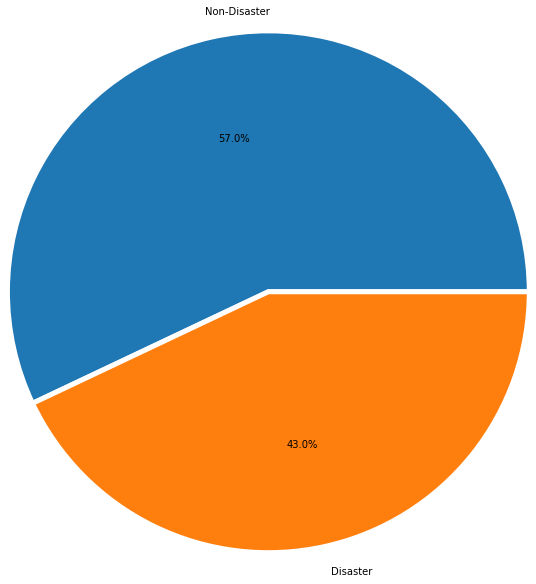

In [ ]:
# Show Distribution of Targets
x = base_train_df['target'].value_counts()/base_train_df['target'].shape[0]

labels = ['Non-Disaster','Disaster']
fig, ax = plt.subplots()
ax.pie(x, labels=labels, radius=3, center=(4, 4),autopct='%1.1f%%',
       wedgeprops={"linewidth": 5, "edgecolor": "white"}, frame=False)

plt.show()

Text(0.5, 1.0, 'Most Used Keywords (disaster)')

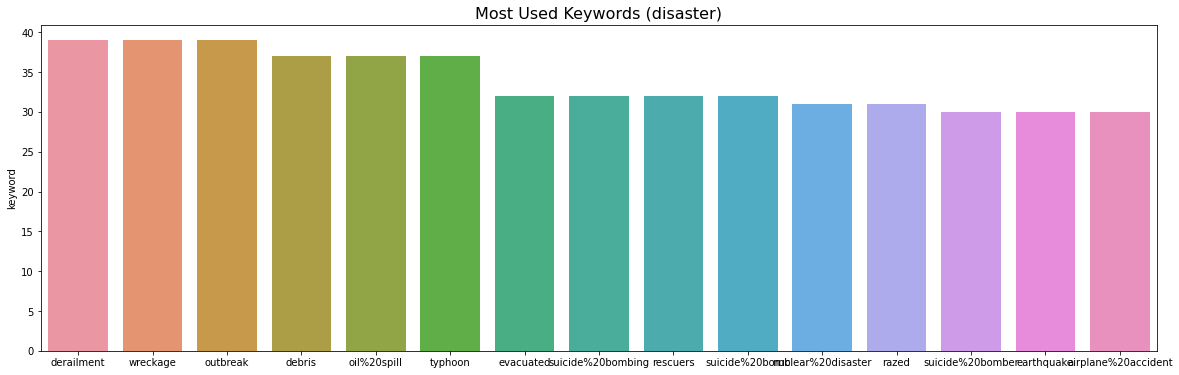

In [ ]:
# Keywords most associated with Disaster tweets
disaster_keywords = base_train_df.loc[base_train_df['target'] == 1, 'keyword']
keywords=disaster_keywords.value_counts()[:15].to_frame()
fig=plt.figure(figsize=(20,6))
sns.barplot(data=keywords,x=keywords.index,y="keyword")
plt.title("Most Used Keywords (disaster)",size=16)

Text(0.5, 1.0, 'Most Used Keywords (non-disaster)')

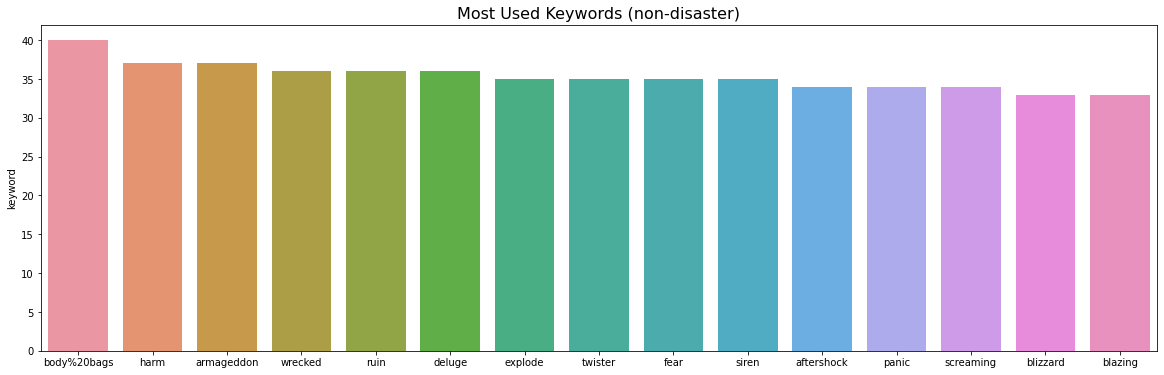

In [ ]:
# Keywords most associated with Non-Disaster tweets
disaster_keywords = base_train_df.loc[base_train_df['target'] == 0, 'keyword']
keywords=disaster_keywords.value_counts()[:15].to_frame()
fig=plt.figure(figsize=(20,6))
sns.barplot(data=keywords,x=keywords.index,y="keyword")
plt.title("Most Used Keywords (non-disaster)",size=16)

In [ ]:
# Number of 'POS', 'NEG', and 'NEU' values for disaster and non-disaster labels
base_train_df.groupby(['sentiment', 'target']).size()

sentiment  target
NEG        0         1681
           1         1673
NEU        0         2023
           1         1471
POS        0          638
           1          127
dtype: int64

## Data Preprocessing - Training and Test Data

In [ ]:
# Drop duplicates (only run once)
## Note: duplicate Tweets are "retweets" from the first tweet; in addition to this, they have different geo-tags in `location` and
## . . . labels in `target`. Because of these inconsistancies in the Retweets, we will only keep the first duplicate (original tweet).
## . . . We believe that the original tweet's label is the accurate label for the tweet.
base_train_df.drop_duplicates(subset="text", keep="first", inplace=True)

In [ ]:
# Show new number of duplicates
unique_tweets = base_train_df['text'].nunique()
duplicate_tweets = base_train_df.shape[0] - unique_tweets
print("Number of duplicates:", duplicate_tweets)

Number of duplicates: 0


In [ ]:
# Converting contractions to expanded words

contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

contractions_re = re.compile('(%s)' % '|'.join(contractions.keys()))

# Define function to expand contractions and showcase
def expand_contractions(s, contractions = contractions):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, s)

expand_contractions("can't stop won't stop")

'cannot stop will not stop'

In [ ]:
# Define a function to strip tweet related characters
def strip_all_entities(x):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split())

# Check functionality
strip_all_entities("""
    @shawn Titanic #tragedy could have been prevented Economic Times: 
    Telegraph.co.uk Titanic tragedy could have been prevented... http://bet.ly/tuN2wx.com
""")

'Titanic tragedy could have been prevented Economic Times Telegraph co uk Titanic tragedy could have been prevented'

In [ ]:
# Define a function to remove stopwords
def remove_stopwords(x):
    return ' '.join([i for i in x.split() if i not in STOPWORDS])

In [ ]:
# Copy `base...` two new dataframes and use `apply` to clean `text`, this preserves the original tweets for our second model
clean_train_df = base_train_df.copy(deep=True)
clean_test_df = base_test_df.copy(deep=True)

In [ ]:
# Clean both `text` and `location`
for df in [clean_train_df, clean_test_df]:
    df['text'] = df['text'].apply(expand_contractions)
    df['text'] = df['text'].apply(strip_all_entities)
    #df['text'] = df['text'].apply(remove_stopwords) NOTE: we are not removing stopwords
    df['location'] = df['location'].apply(lambda x: expand_contractions(x) if pd.notnull(x) else x)
    df['location'] = df['location'].apply(lambda x: strip_all_entities(x) if pd.notnull(x) else x)
    #df['location'] = df['location'].apply(lambda x: remove_stopwords(x) if pd.notnull(x) else x)

In [ ]:
# Fill missing values in `keyword` with 'unknown'
clean_train_df['keyword'] = clean_train_df['keyword'].fillna('unknown')
clean_test_df['keyword'] = clean_test_df['keyword'].fillna('unknown')

In [ ]:
# Create column `location_specific_2word`, which is the last two words of location
clean_train_df['location_specific_2word'] = clean_train_df['location'].str.split().str[-2:].str.join(' ')
clean_test_df['location_specific_2word'] = clean_test_df['location'].str.split().str[-2:].str.join(' ')

# Create column `location_specific_1word`, which is the last word of location
clean_train_df['location_specific_1word'] = clean_train_df['location'].str.split().str[-1]
clean_test_df['location_specific_1word'] = clean_test_df['location'].str.split().str[-1]

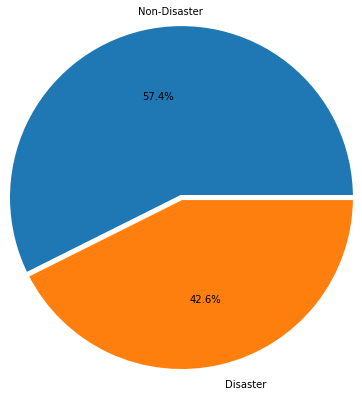

In [ ]:
#Show Distribution of Targets after Preprocessing
x = clean_train_df['target'].value_counts()/clean_train_df['target'].shape[0]

labels = ['Non-Disaster','Disaster']
fig, ax = plt.subplots()
ax.pie(x, labels=labels, radius=2, center=(4, 4),autopct='%1.1f%%',
       wedgeprops={"linewidth": 5, "edgecolor": "white"}, frame=False)

plt.show()

## Finding Polarity (Sentiment) in the Tweets 
**Note: Below cells commented out**


We only will be applying polarity to our dataframe `df_train_final`, since `df_test_final` does not have a *y* value, i.e. the column `target`.

***Note: We are no longer using the package from `flair` to determine sentiement and no longer predicting sentiment after cleaning tweets.***

In [ ]:
#!pip install flair

In [ ]:
#from flair.models import TextClassifier
#from flair.data import Sentence

#sia = TextClassifier.load('en-sentiment')

#def flair_prediction(x):
#    sentence = Sentence(x)
#    sia.predict(sentence)
#    score = sentence.labels[0]
#    if "POSITIVE" in str(score):
#        return "positive"
#    elif "NEGATIVE" in str(score):
#        return "negative"
#    else:
#        return "neutral"
        
#clean_train_df['sentiment'] = clean_train_df['text'].apply(flair_prediction)

2022-04-23 23:59:41,036 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_4.pt not found in cache, downloading to /tmp/tmp8kp1uv7b


100%|██████████| 265512723/265512723 [00:15<00:00, 17311711.01B/s]

2022-04-23 23:59:57,041 copying /tmp/tmp8kp1uv7b to cache at /root/.flair/models/sentiment-en-mix-distillbert_4.pt


2022-04-23 23:59:57,312 removing temp file /tmp/tmp8kp1uv7b
2022-04-23 23:59:57,339 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

## Creating Dummies and Prepending Values

### Augmenting data on `clean_train_df` for `bert-base-cased` model

In [ ]:
# Create dummy variable columns for `sentiment`
dummies = pd.get_dummies(clean_train_df['sentiment'])

## Note: Run only once
clean_train_df = pd.concat([clean_train_df, dummies], axis=1)

In [ ]:
# Prepend the `keyword`, `sentiment`, and `location_specific_2word` to the tweet where there are not null
## Note: We found better accuracy when `location` was omitted.
#clean_train_df['combined_text'] = clean_train_df[['location_specific_2word', 'text']].apply(lambda x: ' '.join(x.dropna()), axis=1)

clean_train_df['combined_text'] = clean_train_df[['keyword', 'text']].apply(lambda x: ' '.join(x.dropna()), axis=1)

clean_train_df['combined_text'] = clean_train_df[['sentiment', 'combined_text']].apply(lambda x: ' '.join(x.dropna()), axis=1)

In [ ]:
# Lets look at our final cleaned dataframe
clean_train_df[70:80]

,id,keyword,location,text,target,sentiment,location_specific_2word,location_specific_1word,NEG,NEU,POS,combined_text
71,102,accident,St Louis MO,stlouis caraccidentlawyer Speeding Among Top C...,0,NEG,Louis MO,MO,1,0,0,NEG accident stlouis caraccidentlawyer Speedin...
72,104,accident,Walker County Alabama,Reported motor vehicle accident in Curry on He...,1,NEU,County Alabama,Alabama,0,1,0,NEU accident Reported motor vehicle accident i...
73,105,accident,Australia,BigRigRadio Live Accident Awareness,1,NEU,Australia,Australia,0,1,0,NEU accident BigRigRadio Live Accident Awareness
74,107,accident,North Carolina,I 77 Mile Marker 31 South Mooresville Iredell ...,1,NEU,North Carolina,Carolina,0,1,0,NEU accident I 77 Mile Marker 31 South Mooresv...
75,109,accident,NaN,RT Sleeping pills double your risk of a car ac...,0,NEG,NaN,NaN,1,0,0,NEG accident RT Sleeping pills double your ris...
76,110,accident,Norf Carolina,By accident they knew what was gon happen,0,NEU,Norf Carolina,Carolina,0,1,0,NEU accident By accident they knew what was go...
77,112,accident,San Mateo County CA,Traffic accident N CABRILLO HWY MAGELLAN AV MI...,1,NEU,County CA,CA,0,1,0,NEU accident Traffic accident N CABRILLO HWY M...
78,113,accident,North Carolina,I 77 Mile Marker 31 to 40 South Mooresville Ir...,1,NEU,North Carolina,Carolina,0,1,0,NEU accident I 77 Mile Marker 31 to 40 South M...
79,114,accident,Njoro Kenya,the pastor was not in the scene of the acciden...,1,NEU,Njoro Kenya,Kenya,0,1,0,NEU accident the pastor was not in the scene o...
80,117,accident,NaN,mom we did not get home as fast as we wished m...,0,NEG,NaN,NaN,1,0,0,NEG accident mom we did not get home as fast a...


In [ ]:
# Finding max length
max_len = max([len(tweet) for tweet in clean_train_df['combined_text']])
min_len = min([len(tweet) for tweet in clean_train_df['combined_text']])

print(f'The longest tweet in the training data is {max_len} characters and the shortest tweet is {min_len} characters')

The longest tweet in the training data is 182 characters and the shortest tweet is 16 characters


### Augmenting data on `bertweet_train_df` for `vinai/bertweet-base` model

In [ ]:
# Create copy of original data for bertweet model
bertweet_train_df = base_train_df.copy(deep=True)
bertweet_test_df = base_test_df.copy(deep=True)

In [ ]:
# Prepend the `keyword` and `sentiment` to the tweet where there are not null
bertweet_train_df['combined_text'] = bertweet_train_df[['keyword', 'text']].apply(lambda x: ' '.join(x.dropna()), axis=1)
bertweet_train_df['combined_text'] = bertweet_train_df[['sentiment', 'combined_text']].apply(lambda x: ' '.join(x.dropna()), axis=1)

In [ ]:
# Lets look at our final uncleaned dataframe for bertweet model
bertweet_train_df[70:80]

,id,keyword,location,text,target,sentiment,combined_text
71,102,accident,"St. Louis, MO",#stlouis #caraccidentlawyer Speeding Among Top...,0,NEG,NEG accident #stlouis #caraccidentlawyer Speed...
72,104,accident,"Walker County, Alabama",Reported motor vehicle accident in Curry on He...,1,NEU,NEU accident Reported motor vehicle accident i...
73,105,accident,Australia,BigRigRadio Live Accident Awareness,1,NEU,NEU accident BigRigRadio Live Accident Awareness
74,107,accident,North Carolina,I-77 Mile Marker 31 South Mooresville Iredell...,1,NEU,NEU accident I-77 Mile Marker 31 South Mooresv...
75,109,accident,NaN,RT @SleepJunkies: Sleeping pills double your r...,0,NEG,NEG accident RT @SleepJunkies: Sleeping pills ...
76,110,accident,Norf Carolina,'By accident' they knew what was gon happen ht...,0,NEU,NEU accident 'By accident' they knew what was ...
77,112,accident,"San Mateo County, CA",Traffic accident N CABRILLO HWY/MAGELLAN AV MI...,1,NEU,NEU accident Traffic accident N CABRILLO HWY/M...
78,113,accident,North Carolina,I-77 Mile Marker 31 to 40 South Mooresville I...,1,NEU,NEU accident I-77 Mile Marker 31 to 40 South M...
79,114,accident,"Njoro, Kenya",the pastor was not in the scene of the acciden...,1,NEU,NEU accident the pastor was not in the scene o...
80,117,accident,NaN,mom: 'we didn't get home as fast as we wished'...,0,NEG,NEG accident mom: 'we didn't get home as fast ...


In [ ]:
# Finding max length
max_len = max([len(tweet) for tweet in bertweet_train_df['combined_text']])
min_len = min([len(tweet) for tweet in bertweet_train_df['combined_text']])

print(f'The longest tweet in the training data is {max_len} characters and the shortest tweet is {min_len} characters')

The longest tweet in the training data is 168 characters and the shortest tweet is 12 characters


In [ ]:
# Make sure original dataframe was preserved
base_train_df.head()

,id,keyword,location,text,target,sentiment
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,NEU
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,NEU
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,NEU
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,NEU
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,NEU


##Model: BERT, `bert-base-cased`

### Preparing BERT



In [ ]:
#tf.keras.backend.clear_session()
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

### Prepping the Data for BERT

In [ ]:
# Recreate the `train_test_split` datasets using the new `combined_text` field
x = clean_train_df['combined_text']
y = clean_train_df['target']

# Create a train and remaining set on 70% of dataframe
x_train, x_rem, y_train, y_rem = train_test_split(x, y, 
                                                  train_size=0.70, 
                                                  stratify=y,
                                                  random_state = 123)

# Create a valid and test set on remaing 30% of x and y; 55/45 split for valid and test, respectively
x_valid , x_test,  y_valid, y_test = train_test_split(x_rem, y_rem, 
                                                      train_size=0.55, 
                                                      stratify=y_rem, 
                                                      random_state = 123)

print("Training x and y shape:", x_train.shape, y_train.shape)
print("Validation x and y shape:", x_valid.shape, y_valid.shape)
print("Test x and y shape:", x_test.shape, y_test.shape )

Training x and y shape: (5252,) (5252,)
Validation x and y shape: (1238,) (1238,)
Test x and y shape: (1013,) (1013,)


In [ ]:
# Use BERT tokenizer to get embeddings
text_train = x_train.values.tolist()
text_valid = x_valid.values.tolist()
text_test = x_test.values.tolist()

max_length = 200
x_train = bert_tokenizer(text_train,
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')

y_train = np.array(y_train)

x_valid = bert_tokenizer(text_valid,
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')

y_valid = np.array(y_valid)

x_test = bert_tokenizer(text_test,
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')

y_test = np.array(y_test)

### Running the BERT Model on Training and Validation Data

In [ ]:
# Defining checkpoints
checkpoint_filepath = "BERT.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5"

model_checkpoint_callback = ModelCheckpoint(
                                            filepath=checkpoint_filepath,
                                            save_weights_only=True,
                                            monitor='val_loss',
                                            mode='min',
                                            save_best_only=True
                                            )

earlyStopping = EarlyStopping(
                              monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto',
                              baseline=None, restore_best_weights=True # Need to remove 'restore_best_weights' to load_weights
                              )

In [ ]:
# Defining BERT model
model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)

# Randomly select learning rate at 1e-5
model.compile(
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=tf.metrics.SparseCategoricalAccuracy(),
              )

model.summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_75 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 108,311,810
Trainable params: 108,311,810
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fit the model
model.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
          y_train,
          validation_data=([x_valid.input_ids, x_valid.token_type_ids, x_valid.attention_mask],
                           y_valid),
          epochs=10,
          batch_size=32,
          callbacks=[earlyStopping, model_checkpoint_callback])

Epoch 1/10
165/165 [==============================] - 153s 840ms/step - loss: 0.5135 - sparse_categorical_accuracy: 0.7578 - val_loss: 0.4521 - val_sparse_categorical_accuracy: 0.7981
Epoch 2/10
165/165 [==============================] - 135s 821ms/step - loss: 0.3945 - sparse_categorical_accuracy: 0.8372 - val_loss: 0.3950 - val_sparse_categorical_accuracy: 0.8336
Epoch 3/10
165/165 [==============================] - 134s 813ms/step - loss: 0.3308 - sparse_categorical_accuracy: 0.8661 - val_loss: 0.4082 - val_sparse_categorical_accuracy: 0.8328
Epoch 4/10
165/165 [==============================] - 134s 813ms/step - loss: 0.2659 - sparse_categorical_accuracy: 0.8989 - val_loss: 0.4688 - val_sparse_categorical_accuracy: 0.8328
Epoch 5/10
165/165 [==============================] - 134s 813ms/step - loss: 0.2181 - sparse_categorical_accuracy: 0.9227 - val_loss: 0.4878 - val_sparse_categorical_accuracy: 0.8320
Epoch 6/10
165/165 [==============================] - 134s 813ms/step - loss: 0.

In [ ]:
# Score `bert-base-cased` without loaded weights
score = model.evaluate([x_test.input_ids, 
                        x_test.token_type_ids, 
                        x_test.attention_mask], 
                       y_test, 
                       verbose=0)

print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.33877032995224
Test accuracy: 0.8647581338882446


In [ ]:
# Score with the loaded weights
model.load_weights('/content/BERT.epoch02-loss0.40.hdf5')

score = model.evaluate([x_test.input_ids, 
                        x_test.token_type_ids, 
                        x_test.attention_mask], 
                       y_test, 
                       verbose=0)

print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.33877032995224
Test accuracy: 0.8647581338882446


## Model: DistilBERT

### Preparing DistilBERT

In [ ]:
MODEL_NAME = 'distilbert-base-uncased-finetuned-sst-2-english'
BATCH_SIZE = 32
N_EPOCHS = 5

### Preparing Data for DistilBERT

In [ ]:
# Recreate the Train Test Split Datasets using the new combined text field
x = clean_train_df['combined_text']
y = clean_train_df['target']

# Create a train and remaining set on 75% of dataframe
x_train, x_rem, y_train, y_rem = train_test_split(x, y, 
                                                  train_size=0.75, 
                                                  stratify=y,
                                                  random_state = 123)

# Create a valid and test set on remaing 25% of x and y; 55/45 split
x_valid , x_test,  y_valid, y_test = train_test_split(x_rem, y_rem, 
                                                      train_size=0.55, 
                                                      stratify=y_rem, 
                                                      random_state = 123)

print("Training x and y shape:", x_train.shape, y_train.shape)
print("Validation x and y shape:", x_valid.shape, y_valid.shape)
print("Test x and y shape:", x_test.shape, y_test.shape )

Training x and y shape: (5627,) (5627,)
Validation x and y shape: (1031,) (1031,)
Test x and y shape: (845,) (845,)


In [ ]:
# Use DistilBERT tokenizer to get embeddings
text_train = x_train.values.tolist()
text_valid = x_valid.values.tolist()
text_test = x_test.values.tolist()

max_length = 200

# Define a tokenizer object
distil_tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

# Tokenize the text
train_encodings = distil_tokenizer(list(x_train.values),
                            truncation=True, 
                            padding=True,
                            max_length=max_length,
                            return_tensors='tf')

y_train = np.array(y_train)

valid_encodings = distil_tokenizer(list(x_valid.values),
                            truncation=True, 
                            padding=True,
                            max_length=max_length,
                            return_tensors='tf')

y_valid = np.array(y_valid)

test_encodings = distil_tokenizer(list(x_test.values),
                            truncation=True, 
                            padding=True,
                            max_length=max_length,
                            return_tensors='tf')

y_test = np.array(y_test)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

### Running DistilBERT on Training and Validation

In [ ]:
distil_train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), list(y_train)))

distil_valid_dataset = tf.data.Dataset.from_tensor_slices((dict(valid_encodings), list(y_valid)))

distil_test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), list(y_test)))

In [ ]:
model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME)

# Chose the optimizer
optimizerr = tf.keras.optimizers.Adam(learning_rate=5e-5)

# Define the loss function 
losss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Build the model
model.compile(optimizer=optimizerr,
              loss=losss,
              metrics=['accuracy'])

# Train the model 
model.fit(distil_train_dataset.shuffle(len(x_train)).batch(BATCH_SIZE),
          validation_data=distil_valid_dataset.shuffle(len(x_valid)).batch(BATCH_SIZE),
          epochs=N_EPOCHS,
          batch_size=BATCH_SIZE)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized: ['dropout_95']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
176/176 [==============================] - 32s 139ms/step - loss: 0.5011 - accuracy: 0.7864 - val_loss: 0.3706 - val_accuracy: 0.8545
Epoch 2/5
176/176 [==============================] - 23s 132ms/step - loss: 0.3448 - accuracy: 0.8578 - val_loss: 0.3697 - val_accuracy: 0.8545
Epoch 3/5
176/176 [==============================] - 23s 132ms/step - loss: 0.2277 - accuracy: 0.9136 - val_loss: 0.3941 - val_accuracy: 0.8468
Epoch 4/5
176/176 [==============================] - 23s 132ms/step - loss: 0.1364 - accuracy: 0.9499 - val_loss: 0.4622 - val_accuracy: 0.8361
Epoch 5/5
176/176 [==============================] - 23s 132ms/step - loss: 0.0906 - accuracy: 0.9673 - val_loss: 0.5920 - val_accuracy: 0.8244


In [ ]:
# DistilBERT evaluation on the test set
model.evaluate(distil_test_dataset.shuffle(len(x_test)).batch(BATCH_SIZE), 
               return_dict=True, 
               batch_size=BATCH_SIZE)

27/27 [==============================] - 3s 46ms/step - loss: 0.6720 - accuracy: 0.8225


{'accuracy': 0.8224852085113525, 'loss': 0.6719526052474976}

## Model: BERTweet

### Prepare dataframe into dataset

In [ ]:
!pip install datasets

In [ ]:
bertweet_train_df.head()

,id,keyword,location,text,target,sentiment,combined_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,NEU,NEU Our Deeds are the Reason of this #earthqua...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,NEU,NEU Forest fire near La Ronge Sask. Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,NEU,NEU All residents asked to 'shelter in place' ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,NEU,"NEU 13,000 people receive #wildfires evacuatio..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,NEU,NEU Just got sent this photo from Ruby #Alaska...


In [ ]:
from datasets import Dataset

bertweet_dataset = Dataset.from_pandas(bertweet_train_df)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)

def tokenize_function(examples):
    return tokenizer(examples["combined_text"], padding="max_length", truncation=True)

emoji is not installed, thus not converting emoticons or emojis into text. Please install emoji: pip3 install emoji
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# Tokenize using bertweet
tokenized_bertweet_dataset = bertweet_dataset.map(tokenize_function, batched=True)

  0%|          | 0/8 [00:00<?, ?ba/s]

In [ ]:
tokenized_bertweet_dataset = tokenized_bertweet_dataset.train_test_split(test_size=0.3)

### Train

In [ ]:
data_collator = DefaultDataCollator(return_tensors="tf")

In [ ]:
tokenized_bertweet_dataset['train']

Dataset({
    features: ['id', 'keyword', 'location', 'text', 'target', 'sentiment', 'combined_text', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 5252
})

In [ ]:
remaining_dataset = tokenized_bertweet_dataset['test'].train_test_split(test_size=0.45)

In [ ]:
remaining_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'target', 'sentiment', 'combined_text', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1238
    })
    test: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'target', 'sentiment', 'combined_text', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1013
    })
})

In [ ]:
tf_bertweet_train_dataset = tokenized_bertweet_dataset['train'].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["target"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)

tf_bertweet_valid_dataset = remaining_dataset['train'].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["target"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=8,
)

tf_bertweet_test_dataset = remaining_dataset['test'].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["target"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=8,
)

### Compile and Fit

In [ ]:
checkpoint_filepath = "BERTweet.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5"

model_checkpoint_callback = ModelCheckpoint(
                                            filepath=checkpoint_filepath,
                                            save_weights_only=True,
                                            monitor='val_loss',
                                            mode='min',
                                            save_best_only=True
                                            )

earlyStopping = EarlyStopping(
                              monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto',
                              baseline=None, restore_best_weights=True 
                              )

In [ ]:
bertweet = TFAutoModelForSequenceClassification.from_pretrained("vinai/bertweet-base", num_labels=2)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
batch_size = 8
num_epochs = 10
num_train_steps = (len(tokenized_bertweet_dataset['train']) // batch_size) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-7,
    end_learning_rate=0.,
    decay_steps=num_train_steps
)

In [ ]:
bertweet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_scheduler),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy(),
)

bertweet.summary()

Model: "tf_roberta_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 134309376 
 )                                                               
                                                                 
 classifier (TFRobertaClassi  multiple                 592130    
 ficationHead)                                                   
                                                                 
Total params: 134,901,506
Trainable params: 134,901,506
Non-trainable params: 0
_________________________________________________________________


In [ ]:
bertweet.load_weights(
    "/content/drive/MyDrive/MSBC_5190_Project/Trained Weights/vinai-bertweet-base/BERTweet.epoch04-loss0.25-best.hdf5"
    )

bertweet.fit(tf_bertweet_train_dataset, 
             validation_data=tf_bertweet_valid_dataset, 
             epochs=10,
             callbacks=[earlyStopping, model_checkpoint_callback])

Epoch 1/10
656/656 [==============================] - 191s 268ms/step - loss: 0.2489 - sparse_categorical_accuracy: 0.9122 - val_loss: 0.2208 - val_sparse_categorical_accuracy: 0.9265
Epoch 2/10
656/656 [==============================] - 174s 265ms/step - loss: 0.2370 - sparse_categorical_accuracy: 0.9141 - val_loss: 0.2189 - val_sparse_categorical_accuracy: 0.9273
Epoch 3/10
656/656 [==============================] - 173s 264ms/step - loss: 0.2320 - sparse_categorical_accuracy: 0.9169 - val_loss: 0.2198 - val_sparse_categorical_accuracy: 0.9249
Epoch 4/10
656/656 [==============================] - 172s 262ms/step - loss: 0.2324 - sparse_categorical_accuracy: 0.9165 - val_loss: 0.2205 - val_sparse_categorical_accuracy: 0.9257
Epoch 5/10
656/656 [==============================] - 172s 262ms/step - loss: 0.2237 - sparse_categorical_accuracy: 0.9217 - val_loss: 0.2232 - val_sparse_categorical_accuracy: 0.9216
Epoch 6/10
656/656 [==============================] - 172s 262ms/step - loss: 0.

In [ ]:
# Score the model without loaded weights
score = bertweet.evaluate(tf_bertweet_test_dataset, verbose=0)

print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.23874671757221222
Test accuracy: 0.9190523028373718


In [ ]:
# Score the model with loaded weights
bertweet.load_weights(
    "/content/drive/MyDrive/MSBC_5190_Project/Trained Weights/vinai-bertweet-base/BERTweet.epoch04-loss0.25-best.hdf5"
    )

score = bertweet.evaluate(tf_bertweet_test_dataset, verbose=0)

print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.23766858875751495
Test accuracy: 0.9239881634712219


### Using bertweet model and its weights to make predictions

In [ ]:
preds = bertweet.predict(tf_bertweet_test_dataset)["logits"]

In [ ]:
class_preds = np.argmax(preds, axis=1)
print(preds.shape, class_preds.shape)

(1013, 2) (1013,)


In [ ]:
from datasets import load_metric

metric = load_metric("glue", "mrpc")
metric.compute(predictions=class_preds, references=remaining_dataset['test']['target'])

{'accuracy': 0.9239881539980257, 'f1': 0.9038701622971286}

In [ ]:
from sklearn import metrics

In [ ]:
confusion_matrix = metrics.confusion_matrix(remaining_dataset['test']['target'], 
                                            class_preds)
print(confusion_matrix)

[[574  26]
 [ 51 362]]


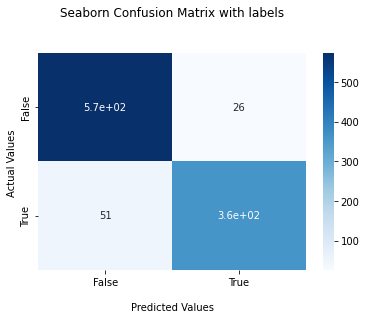

In [ ]:
ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
tf.math.confusion_matrix(
    remaining_dataset['test']['target'],
    class_preds,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[574,  26],
       [ 51, 362]], dtype=int32)>